In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import shutil
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML, display, Markdown
import tabulate
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
import graphviz
from GraphVizUtil import *
from GraphVizFormats import *
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
sb.set(style='darkgrid', font_scale=1.2)

def filter_descriptions(tech_comm_desc):
    try:
        tech_comm_desc = tech_comm_desc.values[0][0].replace('#', '').replace('"','').replace("\n",'').strip()
    except:
        tech_comm_desc = 'No description provided'
    return tech_comm_desc

def create_args_flowd(df_graph):
    nodes, tech, ltech, to_tech, from_tech = set(), set(), set(), set(), set()
    for ind,row in df_graph.iterrows():
        #descriptions:
        input_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['input_comm'] + "'", con))
        output_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['output_comm'] + "'", con))
        tech_des = filter_descriptions(pd.read_sql("SELECT tech_desc FROM technologies WHERE tech='" + row['tech'] + "'", con))

        if 'ethos' in row['input_comm']:
            ltech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')
        else :
            nodes.add('"' + row['input_comm'] + '"' +  ' [tooltip = "' + input_comm_des + '"]')
        nodes.add('"' + row['output_comm'] + '"' +  ' [tooltip = "' + output_comm_des + '"]')
        tech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')

        if row['input_comm'] != 'ethos':
            to_tech.add('"%s"' % row['input_comm'] + '\t->\t"%s"' % row['tech']) 
        from_tech.add('"%s"' % row['tech'] + '\t->\t"%s"' % row['output_comm'])
    args = dict(
    enodes = "".join('%s;\n\t\t' % x for x in nodes),
    tnodes = "".join('%s;\n\t\t' % x for x in tech),
    iedges = "".join('%s;\n\t\t' % x for x in to_tech),
    oedges = "".join('%s;\n\t\t' % x for x in from_tech),
    snodes = ";".join('%s' %x for x in ltech),
    )
    return args

def return_format_colors():
    colors = {}
    colors.update(getColorConfig(False))
    return colors, quick_run_dot_fmt

def return_flowd_table(final_dem, level=1):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    iterval=0
    if level!=0:
        while len(inputs)>0:
            df_append = df[df['output_comm'].isin(inputs)]
            df_sel = pd.concat([df_sel, df_append])
            inputs = df_append['input_comm'].unique()
            iterval+=1
            if iterval>level-1:
                break
    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

def return_flowd_table_fwds(final_dem):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    outputs = df_sel['output_comm'].unique()

    iterval=0
    while len(inputs)>0:
        df_append = df[df['output_comm'].isin(inputs)]
        df_sel = pd.concat([df_sel, df_append])
        inputs = df_append['input_comm'].unique()
        iterval+=1
        if iterval>2:
            break
    iterval=0
    while len(outputs)>0:
        df_append = df[df['input_comm'].isin(outputs)]
        df_sel = pd.concat([df_sel, df_append])
        outputs = df_append['output_comm'].unique()
        iterval+=1
        if iterval>=0:
            break

    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

con = sqlite3.connect(r'../US_National_oilsupply.sqlite') #change path to database
cur = con.cursor()   
con.text_factory = str 

def controls_rows(w):
    controls = HBox(w.children[:-1], layout = Layout(flex_flow='row wrap', width='max-content'))
    output = w.children[-1]
    display(VBox([controls, output],  layout = Layout(flex_flow='columns wrap', width='max-content', size=10)))
    
#https://www.eia.gov/energyexplained/units-and-calculators/
btu_per_oil_bbl = 5698000
PJ_per_oil_bbl = btu_per_oil_bbl*1.05506e-12

# 1. Introduction
The fuel supply sector consists of commodities and technologies that provide a) refined petroleum products, b) coal, c) natural gas and d) biomass resources to the energy modeling system. These resources are discussed separately in the sections that follow.

## 1.1 Oil supply and petroleum products
The petroleum products sector is characterized by crude oil imports, refining and transport from a PADD region to the US consuming regions. In the current database, we assume a single Petroleum Administration for Defense District (PADD) region that can supply crude oil and produce refined products that are transported to the OEO regions. This may be expanded to the <a href="https://www.eia.gov/todayinenergy/detail.php?id=4890" rel="nofollow">five PADD</a> regions or some subset, as the database evolves. Note that the current version of the database is based on the US_National.sql file. This will be updated to include these modifications in the US_Regional database as well, shortly.

### 1.1.1 Crude oil supply
The global crude oil resource curve is represented by data from 
<a href="https://www.nature.com/articles/s41467-020-17679-3" rel="nofollow">Pye et al, 2020</a> (an updated version of the database presented in supplementary materials, Supp Figure 24, was obtained by communication from Daniel Welsby at UCL). This dataset was used to select crude oil resource availability and cost data for the US and other regions that the US imports crude oil from. The crude resources are divided into 8 different types as shown in the table below. 

|Name| Crude resource type|
| :--- | :--- |
|CP	|Proved conventional reserves|
|CR	|Conventional reserve additions|
|CN	|Conventional new discovery|
|LT	|Light tight oil|
|MOS	|Mined oil sands|
|IOS	|In situ oil sands|
|UH	|Ultra heavy|
|AR	|Arctic oil|

The UCL dataset represents cumulative crude oil resources across 16 world regions. Of these regions, the US imports crude oil from the Middle East (MEA), Central and South America (CSA), Africa (AFR), Mexico (MEX), and Canada (CAN). Resource data for these regions and the US are therefore considered here. The tool below can be used to plot resource curves for these regions. Each 'step' in the curve refers to a type of crude oil resource within a region, at a specific supply cost and estimated total resource available.

In [2]:
def oil_supply_curve(con):
    df = pd.read_sql("SELECT * FROM MaxResource WHERE regions LIKE 'PADD%' AND tech LIKE 'IMPOIL%'", con)
    df_costs = pd.read_sql("SELECT * FROM CostVariable WHERE regions LIKE 'PADD%' AND tech LIKE 'IMPOIL%'", con)
    df = df.merge(df_costs[['regions','tech','periods', 'cost_variable']], on=['regions', 'tech']).drop(columns='periods')
    df = df.drop_duplicates()
    df['maxres'] /=1000

    cb = dict()
    cb['CP'] = '#fff7fb'
    cb['CR'] = '#ece2f0'
    cb['CN'] = '#d0d1e6'
    cb['LT'] = '#a6bddb'
    cb['MOS'] = '#67a9cf'
    cb['IOS'] = '#3690c0'
    cb['UH'] = '#02818a'
    cb['AR'] = '#016450'
    
    res_map = dict()
    res_map['CP'] = 1
    res_map['CR'] = 2
    res_map['CN'] = 3
    res_map['LT'] = 4
    res_map['MOS'] = 5
    res_map['IOS'] = 6
    res_map['UH'] = 7
    res_map['AR'] = 8
    
    res_map_rev = dict((v,k) for k, v in res_map.items())


    sel_region = 'PADD1'
    def display_supply_curve(region):
        fig, ax = plt.subplots(figsize=(10,8))
        df_sel = df[df['maxres_notes'].apply(lambda x: x.split('_')[2])==region]
        df_sel.sort_values(by='cost_variable', inplace=True)
        df_sel['maxres'] = df_sel['maxres'].cumsum()
        start =0 
        for ind, row in df_sel.iterrows():
            x = start + (row['maxres']-start)/2
            plt.bar(x, row['cost_variable'] , width=row['maxres']-start, color=cb[row['maxres_notes'].split('_')[4]], \
                    label=row['maxres_notes'].split('_')[4])
            start = row['maxres']
        plt.legend()
        handles, labels = ax.get_legend_handles_labels()
        labels = [res_map[x] for x in labels]
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        unique.sort(key = lambda x: x[1])
        unique2=[]
        for i in np.arange(len(unique)):
            unique2.append((unique[i][0], res_map_rev[unique[i][1]]))
        ax.legend(*zip(*unique2), frameon=False)

        plt.ylabel('Supply costs ($/PJ)')
        plt.xlabel('Cumulative resource (EJ)')
    
    

    regions = df['maxres_notes'].apply(lambda x: x.split('_')[2]).unique()
    if len(regions)==1:
        regions = np.append('',regions)
    w2 = widgets.Select(options=regions)
    w = widgets.interactive(display_supply_curve, region=w2)

    controls_rows(w)

oil_supply_curve(con)

#### 1.1.1.1 Limits on regional annual crude oil production
The US EIA reports <a href="https://www.eia.gov/dnav/pet/PET_CRD_CRPDN_ADC_MBBL_A.htm" rel="nofollow">historic data crude oil production in the US.</a> They also report <a href="https://www.eia.gov/dnav/pet/pet_move_impcus_a2_nus_epc0_im0_mbbl_a.htm" rel="nofollow">historic crude oil imports to the US by country of origin.</a> A table of historic (between 2015 and 2020) crude oil production and/or imports by regions that corresponded to the UCL resource dataset was developed using these EIA sources. The maximum annual production and/or imports in this time period for each region were used to constrain annual oil production/imports from these regions in first time step of the model horizon.

In [3]:
def regional_growthseed(con):
    df = pd.read_sql("SELECT * FROM GrowthRateSeed WHERE tech LIKE 'IMPOIL_%' AND growthrate_seed_notes LIKE 'Crude %'", con)
    df['growthrate_seed_notes'] = df['growthrate_seed_notes'].str.replace('Crude oil from ', '')
    df.sort_values(by='growthrate_seed', inplace=True)
    header = ['Region' , 'Maximum historic production or imports (PJ/year)']
    display(HTML(tabulate.tabulate(df[['growthrate_seed_notes', 'growthrate_seed']].set_index('growthrate_seed_notes'), \
                                   header,  floatfmt=".0f" , tablefmt='html')))
regional_growthseed(con)

Region,Maximum historic production or imports (PJ/year)
AFR,962
MEX,1510
CSA,3443
MEA,3800
CAN,8369
USA,26876


#### 1.1.1.2 Limits on annual crude oil production by resource step
In addition to the annual limits on regional production or imports, each resource step in the global resource curve was also assigned an annual production limit for the first time step of the model horizon. For resource steps in the US and Canada that had historic production, this limit was assigned as the maximum of historic production between 2015 and 2020. For all other resource steps in these regions, and for all resource steps in the other importing regions, a seed value of 0.1% (0.5% over 5 years, for conventional) to 1% (5% over 5 years for unconventional) of the cumulative resource in that step was used, based on assumptions in <a href="https://discovery.ucl.ac.uk/id/eprint/1418473/2/131106%20Christophe%20McGlade_PhD%20Thesis.pdf" rel="nofollow">McGlade 2013.</a> These limits will be revisited when further data are available.

For each resource type within a region, the total resource is divided into three steps that vary in cost and  supply. These limits on annual production, however, are only available as a sum across all three steps. Therefore, annual limits are assigned to each step following the ratio of the resource available in that step to the total resources available across all three steps.

##### United States
Historic US light tight oil production was obtained from the <a href="https://www.eia.gov/energyexplained/oil-and-petroleum-products/data/US-tight-oil-production.xlsx" rel="nofollow">US EIA.</a> Further, using crude oil production data by API category from the <a href="https://www.eia.gov/dnav/pet/pet_crd_api_adc_mbblpd_m.htm" rel="nofollow">US EIA</a>, historic US ultra heavy oil production was estimated (assumed to be oil with API < 20). This resource also provided estimates of total historic crude oil production in the US, and was used to estimate historic conventional oil production (as the difference between the total production, and production from ultra-heavy and light tight oil).

#### Canada
Historic Canadian light tight oil production was obtained from the <a href="https://neb-one.gc.ca/en/data-analysis/canada-energy-future/2020conventional/index.html" rel="nofollow">Canada Energy Regulator.</a> They also report historic total crude oil production, as well as estimates for mined and in-situ bitumen production <a href="https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/crude-oil-petroleum-products/statistics/estimated-production-canadian-crude-oil-equivalent.html" rel="nofollow">here.</a> These resources were used to estimate historic conventional oil production (as the difference between the total production, and production from oil sands and light tight oil).

#### 1.1.1.2 Growth rate constraints on annual production

Maximum annual growth rate values were assigned to each resource step based on crude oil type, using assumptions outlined in the  <a href="https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-17679-3/MediaObjects/41467_2020_17679_MOESM1_ESM.pdf" rel="nofollow">supplementary information in Pye et al, 2020</a>, Table 11a. In addition, regional growth rates were assumed to equal the maximum of annual growth rates across all crude oil resource types.


In [4]:
def regional_growthmax(con):
    df = pd.read_sql("SELECT * FROM GrowthRateMax WHERE tech LIKE 'IMPOIL_%' AND growthrate_max_notes LIKE 'Crude %'", con)
    df['growthrate_max_notes'] = df['growthrate_max_notes'].str.replace('Crude oil from ', '')
    df.sort_values(by='growthrate_max', inplace=True)
    header = ['Region' , 'Maximum growth rate']
    display(HTML(tabulate.tabulate(df[['growthrate_max_notes', 'growthrate_max']].set_index('growthrate_max_notes'), \
                                   header,  floatfmt=".1f" , tablefmt='html')))

def regional_growthmax_step(con):
    df = pd.read_sql("SELECT * FROM GrowthRateMax WHERE tech LIKE 'IMPOIL_%' AND growthrate_max_notes NOT LIKE 'Crude %'", con)
    df['growthrate_max_notes'] = df['growthrate_max_notes'].map(lambda x: x.split('_')[4])
    df = df[['growthrate_max_notes', 'growthrate_max']].drop_duplicates()
    df.sort_values(by='growthrate_max', inplace=True)
    header = ['Resource' , 'Maximum growth rate']
    display(HTML(tabulate.tabulate(df[['growthrate_max_notes', 'growthrate_max']].set_index('growthrate_max_notes'), \
                                   header,  floatfmt=".1f" , tablefmt='html')))
regional_growthmax_step(con)
regional_growthmax(con)

Resource,Maximum growth rate
LT,1.1
MOS,1.1
UH,1.1
IOS,1.1
AR,1.1
CP,1.4
CN,1.4
CR,1.4


Region,Maximum growth rate
MEA,1.4
CSA,1.4
AFR,1.4
MEX,1.4
USA,1.4
CAN,1.4


#### 1.1.1.3 Emissions from crude oil production
These are assumed to be 70 kt/PJ for all crude oil categories (average of emissions factors of several imported petroluem products within the database currently). These values will be updated shortly.

### 1.1.2 Demand for exports
Since 2015, the US has seen an increase in exports of crude oil and petroluem products to countries across the world - in 2020, the US exported a total of 3,114 million barrels. As a placeholder, this demand is assumed to remain flat through from 2020 to 2050 in our modeling framework. We do not differentiate between demand for crude oil and petroluem products, but assume that all of this demand can be met entirely by crude oil that is domestically produced or imported.

Meeting oil exports demand

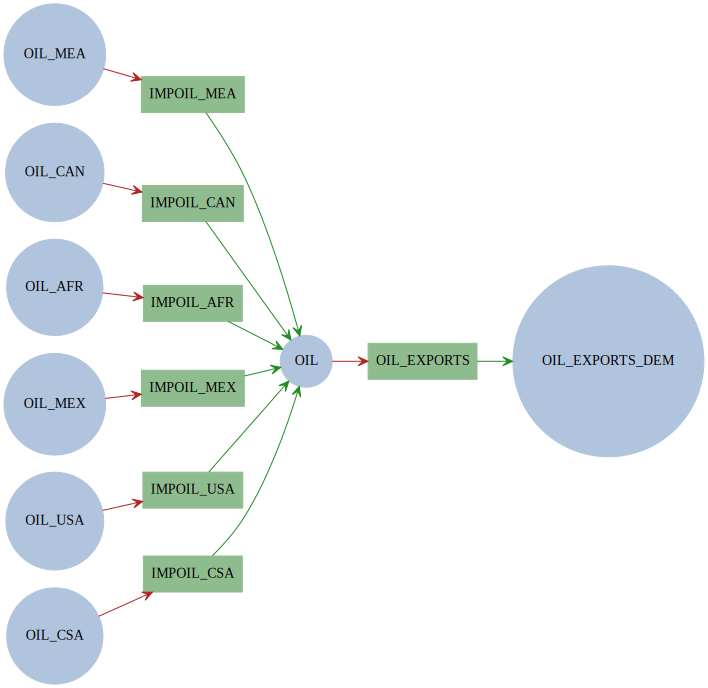

In [5]:
def refinery_network_diagram(con):
    final_dem = 'OIL_EXPORTS_DEM'
    df_graph = return_flowd_table(final_dem, 1)
    args = create_args_flowd(df_graph)
    colors, quick_run_dot_fmt = return_format_colors()
    args.update(colors)
    #o_str = 'rankdir = "LR" ;'
    #r_str = 'rankdir = "LR" ; \n\t size="12,12";'
    #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
    dot_graph = quick_run_dot_fmt % args
    display(Markdown('Meeting oil exports demand'))
    display(graphviz.Source(dot_graph))
    
refinery_network_diagram(con)

### 1.1.3 Crude oil refining
The crude oil refinery in each PADD region is represented as a process that takes in a single input (oil) to produce multiple outputs. The refining process has a distribution of petroluem product outputs as shown in the network diagram below. The output distribution can include products such as gasoline, diesel, residual and distillate fuel oil. We currently do not include any energy inputs or emissions associated with refineries, but this will be updated shortly.

Network diagram for a representative refinery

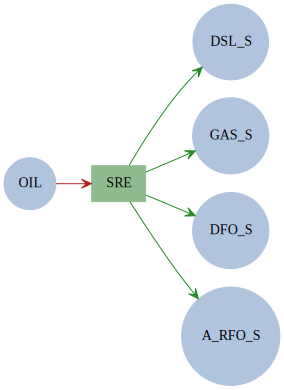

In [6]:
def refinery_network_diagram(con):
    final_dem = 'SRE'
    df_graph = return_flowd_table(final_dem, 0)
    args = create_args_flowd(df_graph)
    colors, quick_run_dot_fmt = return_format_colors()
    args.update(colors)
    #o_str = 'rankdir = "LR" ;'
    #r_str = 'rankdir = "LR" ; \n\t size="12,12";'
    #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
    dot_graph = quick_run_dot_fmt % args
    display(Markdown('Network diagram for a representative refinery'))
    display(graphviz.Source(dot_graph))
    
refinery_network_diagram(con)

The product distribution from the refinery is represented in the TechOutputSplit table (as mass fractions) - representative values from EIA have been selected in this iteration. Each pathway from input to output through the refinery technology has an associated efficiency value. The US refining capacity, as reported by the <a href="https://www.eia.gov/todayinenergy/detail.php?id=44237#:~:text=U.S.%20operable%20atmospheric%20crude%20oil,b%2Fcd%20the%20year%20before." rel="nofollow">EIA</a> for 2020, was used to develop an estimate of existing refinery capacity. The total output mass fractions equal 95% to allow the model some flexibility in refinery outputs. 

In [7]:
df = pd.read_sql("SELECT regions, tech, output_comm, to_split FROM TechOutputSplit WHERE regions LIKE 'PADD%' AND tech LIKE 'SRE%'", con)
df = df.groupby(['regions', 'tech', 'output_comm']).mean().reset_index()
df_eff = pd.read_sql("SELECT regions, tech, vintage , input_comm, output_comm, efficiency FROM Efficiency WHERE regions LIKE 'PADD%' AND tech LIKE 'SRE%'", con)
df_cap = pd.read_sql("SELECT regions, tech, vintage, exist_cap FROM ExistingCapacity WHERE regions LIKE 'PADD%' AND tech LIKE 'SRE%'", con)
df_eff = df_eff.merge(df_cap, on = ['regions', 'tech', 'vintage'])
df = df.merge(df_eff, on = ['regions', 'tech', 'output_comm'])
cols = ['regions', 'input_comm', 'tech', 'output_comm', 'efficiency', 'exist_cap' ,'to_split']
df = df[cols]
df['efficiency'] *=100
df['to_split'] *=100
df['exist_cap'] /=PJ_per_oil_bbl*10**6
header = ['regions', 'input','technology', 'output', 'efficiency (%)', 'existing capacity (million bbls/year)', 'output mass fraction (%)']
display(HTML(tabulate.tabulate(df.set_index('regions'), header,  floatfmt=".1f" , tablefmt='html')))


regions,input,technology,output,efficiency (%),existing capacity (million bbls/year),output mass fraction (%)
PADD1,OIL,SRE,A_RFO_S,100.0,6935.0,5.0
PADD1,OIL,SRE,DFO_S,100.0,6935.0,20.0
PADD1,OIL,SRE,DSL_S,100.0,6935.0,25.0
PADD1,OIL,SRE,GAS_S,100.0,6935.0,45.0


Variable costs are assigned per unit of throughput, currently based on values in the grey literature.

In [8]:
df_cost = pd.read_sql("SELECT regions, tech, vintage, periods, cost_variable FROM CostVariable WHERE regions LIKE 'PADD%' AND tech LIKE 'SRE%'", con)
df_cost['cost_variable'] *= PJ_per_oil_bbl*10**6
header = ['regions', 'technology','vintage', 'periods', 'variable cost ($/bbl)']
display(HTML(tabulate.tabulate(df_cost.set_index('regions'), header,  floatfmt=".1f" , tablefmt='html')))

regions,technology,vintage,periods,variable cost ($/bbl)
PADD1,SRE,2015,2020,5.0
PADD1,SRE,2015,2025,5.0
PADD1,SRE,2015,2030,5.0
PADD1,SRE,2015,2035,5.0
PADD1,SRE,2015,2040,5.0
PADD1,SRE,2015,2045,5.0
PADD1,SRE,2015,2050,5.0


#### 1.1.3.1 Products transport
Refined products can be transported from a PADD region to a US region using a transport process. The network diagram for gasoline transport is shown below. In this case, the gasoline produced by the refinery in a PADD region has no immediate downstream process or demand, other than the transport process itself. Therefore, a dummy downstream process (SRE1) with an efficiency of 100% was created, in order for the commodity balance constraint to work appropriately. The inputs and outputs of this dummy process are the same (the refined product). The process also has a corresponding row in the ExistingCapacity table, with capacity that equals the refinery process. 

The gas transport process currently does not have any associated fixed or variable costs. Note that transport process from region R1 to R2 must have a corresponding transport technology from R2 to R1. In this case, since no flow of products is expected from the US consuming region back to the PADD region, an efficiency of ~0% is defined for the transport process from the US to the PADD region.

The gas in the US region does not have any local upstream process other than the transport process. Therefore, another dummy process that produced the refined product in the US region was defined with very high variable costs (GAS_LOCAL), so that the model does not assume 'free' gas availability in the US region.

A summary of the dummy processes used are presented below.

Network diagram for products transport

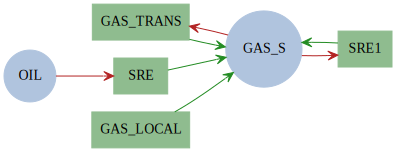

In [9]:
def products_transport_network_diagram(con):
    final_dem = 'GAS_TRANS'
    df_graph = return_flowd_table(final_dem)
    args = create_args_flowd(df_graph)
    colors, quick_run_dot_fmt = return_format_colors()
    args.update(colors)
    #o_str = 'rankdir = "LR" ;'
    #r_str = 'rankdir = "LR" ; \n\t size="12,12";'
    #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
    dot_graph = quick_run_dot_fmt % args
    display(Markdown('Network diagram for products transport'))
    display(graphviz.Source(dot_graph))
    
products_transport_network_diagram(con)

In [10]:

df_eff = pd.read_sql("SELECT regions, tech, vintage , input_comm, output_comm, efficiency FROM Efficiency WHERE tech='GAS_LOCAL' OR tech LIKE 'SRE1%' OR tech='GAS_TRANS'", con)
df_cap = pd.read_sql("SELECT regions, tech, vintage, exist_cap FROM ExistingCapacity WHERE tech='GAS_LOCAL' OR tech LIKE 'SRE1%' OR tech='GAS_TRANS'", con)
df_eff = df_eff.merge(df_cap, on = ['regions', 'tech', 'vintage'])
df = df_eff.copy()
cols = ['regions', 'input_comm', 'tech', 'output_comm', 'efficiency', 'exist_cap']
df = df[cols]
df['efficiency'] *=100
df['exist_cap'] /=PJ_per_oil_bbl*10**6
header = ['regions', 'input','technology', 'output', 'efficiency (%)', 'existing capacity (million bbls/year)', 'output mass fraction (%)']
display(HTML(tabulate.tabulate(df.set_index('regions'), header,  floatfmt=".1f" , tablefmt='html')))


regions,input,technology,output,efficiency (%),existing capacity (million bbls/year)
PADD1,GAS_S,SRE1,GAS_S,100.0,6935.0
PADD1,DSL_S,SRE1,DSL_S,100.0,6935.0
PADD1,DFO_S,SRE1,DFO_S,100.0,6935.0
PADD1,A_RFO_S,SRE1,A_RFO_S,100.0,6935.0
PADD1-US,GAS_S,GAS_TRANS,GAS_S,100.0,6935.0
US-PADD1,GAS_S,GAS_TRANS,GAS_S,0.0,6935.0
US,ethos,GAS_LOCAL,GAS_S,100.0,6935.0


#### 1.1.3.2  Products cost adders
Once the refined products are in the US consuming regions, they pass through another downstream technology that appends any product/region specific cost-adders to the products. These cost-adder technologies also serve a dual purpose of allowing any 'curtailment' that is driven by the assumed refinery slate distribution. For example, if the demand for crude oil refining is set by the gasoline commodity, other products such as diesel may be produced in excess of demand, given the fixed refinery configuration. For these specific technologies, the commodity balance (which is typically modeled as an equality constraint), is modeled as an inequality constraint, where some outputs that are in excess of demand downstream are curtailed.

Network diagram for cost-adders

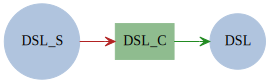

In [11]:
def cost_adders_network_diagram(con):
    final_dem = 'DSL_C'
    df_graph = return_flowd_table(final_dem, 0)
    args = create_args_flowd(df_graph)
    colors, quick_run_dot_fmt = return_format_colors()
    args.update(colors)
    #o_str = 'rankdir = "LR" ;'
    #r_str = 'rankdir = "LR" ; \n\t size="12,12";'
    #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
    dot_graph = quick_run_dot_fmt % args
    display(Markdown('Network diagram for cost-adders'))
    display(graphviz.Source(dot_graph))
    
cost_adders_network_diagram(con)

In [12]:
df_cost = pd.read_sql("SELECT regions, tech, vintage, periods, cost_variable FROM CostVariable WHERE tech LIKE '%_C' AND tech!='IMPELC'", con)
df_cost['cost_variable'] *= PJ_per_oil_bbl*10**6
df_cost = df_cost.groupby(by=['regions', 'tech', 'vintage']).mean().reset_index().drop('periods', axis=1)
header = ['regions', 'technology','vintage', 'mean variable cost ($/bbl)']
display(HTML(tabulate.tabulate(df_cost.set_index('regions'), header,  floatfmt=".1f" , tablefmt='html')))

regions,technology,vintage,mean variable cost ($/bbl)
US,C_DISTOIL_C,2015,1.0
US,C_RFO_C,2015,1.0
US,DSL_C,2015,1.0
US,GAS_C,2015,1.0
US,I_DFO_C,2015,1.0
US,I_RFO_C,2015,1.0
US,RFO_C,2015,1.0
US,R_DISTOIL_C,2015,1.0


#### 1.1.3.3  Imported refinery products
All the refinery products can also be directly 'imported' to a US consuming region, instead of the going through the refinery process. The costs associated with these products comes from the US Annual Energy Outlook (2020?)

In [13]:
df_cost = pd.read_sql("SELECT * FROM CostVariable WHERE tech IN (SELECT DISTINCT(tech) FROM technologies WHERE  sector='supply')\
AND tech LIKE 'IMP%' AND (tech LIKE '%OIL' OR tech LIKE '%RFO' OR tech LIKE '%DFO' OR tech LIKE '%LPG' OR tech LIKE '%DSL' \
OR tech LIKE '%GAS' OR tech LIKE '%KER' OR tech LIKE '%GSL' OR tech LIKE '%JTF' OR tech LIKE '%MGO')", con)
df_cost['cost_variable'] *= PJ_per_oil_bbl*10**6
df_tech = pd.read_sql("SELECT tech, tech_desc FROM technologies", con)
df_cost = df_cost.groupby(by=['regions', 'tech', 'vintage']).mean().reset_index().drop('periods', axis=1)
df_cost = df_cost.merge(df_tech, on='tech')
df_cost['tech_desc'] = df_cost['tech_desc'].str.replace('#','')
header = ['regions', 'technology','vintage', 'mean variable cost ($/bbl)', 'description']
display(HTML(tabulate.tabulate(df_cost.set_index('regions'), header,  floatfmt=".1f" , tablefmt='html')))

regions,technology,vintage,mean variable cost ($/bbl),description
US,IMPCOMDISTOIL,2020,134.0,imported distillate oil to commercial sector
US,IMPCOMLPG,2020,129.8,imported LPG to commercial sector
US,IMPCOMRFO,2020,72.2,imported residual fuel oil to commercial sector
US,IMPINDDFO,2020,133.1,imported distillate fuel oil to industrial sector
US,IMPINDGSL,2020,122.8,import of diesel fuel for the industrial sector
US,IMPINDLPG,2020,98.7,imported LPG to industrial sector
US,IMPINDRFO,2020,82.4,imported residual fuel oil to industrial sector
US,IMPRESDISTOIL,2020,156.7,imported distillate oil to residential sector
US,IMPRESKER,2020,143.1,imported kerosene to residential sector
US,IMPRESLPG,2020,185.6,imported LPG to residential sector


# 2. Technology/commodity description lookup tool <a class="anchor" id="description_look_up"></a>
Use the tool below to search for any key words that may describe a technology or commodity of interest (e.g. heating, cooling). The tool provides a list of all the technologies or commodities in the database that may be relevant to the query.


In [14]:
w = widgets.Text(value='Crude oil')
display(w)
def f(w):
    if len(w)>0:
        df1 = pd.read_sql("SELECT * FROM commodities WHERE comm_desc LIKE '%" + w + "%'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech_desc LIKE '%" + w + "%'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'


        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])
        
        if len(df)>0:
            display(HTML(tabulate.tabulate(df.set_index('comm_tech'),['technology/commodity','type','description'],stralign='left',tablefmt='html')))
        else:
            print('')
    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='Crude oil')

Output()

# 3. Network diagram lookup tool  <a class="anchor" id="network_look_up"></a>
Use the [description lookup tool](#description_look_up) above to identify specific commodity or technology names. Type the name in the box below to generate a corresponding network diagram for that commodity or technology. The slider can be used to view different upstream levels of the network diagram.

In [15]:
w = widgets.Text(value='OIL')
display(w)
def f(w):
    if len(w)>0:
        
        df1 = pd.read_sql("SELECT comm_name, comm_desc FROM commodities WHERE comm_name='" + w + "'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech='" + w + "'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'

        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])

    
        if len(df)>0:
            def show_desc(level):
                display(Markdown(df['desc'][0]))
                final_dem = df['comm_tech'][0]
                df_graph = return_flowd_table(final_dem,level)
                args = create_args_flowd(df_graph)
                colors, quick_run_dot_fmt = return_format_colors()
                args.update(colors)
                #o_str = 'rankdir = "LR" ;'
                #r_str = 'rankdir = "LR" ; \n\t size="8,8";'
                #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
                dot_graph = quick_run_dot_fmt % args
                display(graphviz.Source(dot_graph))
            w2 = widgets.IntSlider(value=1,min=0,max=10,step=1,description='Level:',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
            w = widgets.interactive(show_desc, level=w2)
            controls_rows(w)
        else:
            print('')

    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='OIL')

Output()